In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
#from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
#Draw = lambda *args, **kwargs : None

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine, L2Draw, colorprint, TextColor
L2Draw.drawFunc = Draw
from meshGen import mesh2DLaminates

import numpy as np

modelHalfAir = False




In [2]:
mu0 = 4e-7*np.pi

muAir = 1 * mu0
muFe = 10 * mu0


order0 = 2

In [3]:
D = 0.06
d = 0.02

ff = 0.7


numSheets = 5

maxh_edges = d/numSheets*1/2 * 0.1







## 4. All together with Eddy currents
### 4.1. Reference Solution 

In [4]:
import importlib

import meshGen as mg
mg = importlib.reload(mg)
mesh2DLaminates = mg.mesh2DLaminates
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=[maxh_edges, maxh_edges], fullProblemX=True, onlySmooth = False, onlyRough = False, rotated=True, modelHalfAir=modelHalfAir, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))

print(cMeshRef.dFe)



maxh_edges [0.0002, 0.0002]
Boundaries {'left', 'bottom', 'iright', 'ibottom', 'ileft', 'top', 'itop', 'right'}
Materials {'inner', 'insulation', 'outer'}
0.0028


In [5]:
Draw(meshRef)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [6]:
set(meshRef.GetBoundaries())

{'bottom', 'ibottom', 'ileft', 'iright', 'itop', 'left', 'right', 'top'}

In [7]:
mu = meshRef.MaterialCF({"inner":muFe, "outer":muAir, "insulation":muAir, "gap":muAir, "multiscale":muFe})
def calcRef():
    fesPhi = H1(meshRef, order=order0+1, dirichlet="left|right")
    fes = FESpace([fesPhi])

    trials, tests = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += mu * (-grad(trials[0])) * (-grad(tests[0])) * dx
    a += 1e-3* trials[0] * tests[0] * dx("inner")


    prec = Preconditioner(a, "direct")

    Phi = sol.components[0]

    Phi.Set((1 * x/Norm(x)), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=30, tol = 1e-10, print=True)

    
    
    energy =  Integrate( InnerProduct(mu * ( - grad(Phi)), ( - grad(Phi))), meshRef, definedon=meshRef.Materials("inner|insulation")).real
    
    return sol, energy

sol_ref, energy_ref = calcRef()


Phi = sol_ref.components[0]
H_ref = -grad(Phi)
B_ref = mu  * H_ref


CG iteration 1, residual = 0.0036074343870852476     
CG iteration 2, residual = 1.5922217709282622e-17     


In [8]:
#energy:	3.10067858198899e-07
#eddy current losses:	5.042166093099941e-07


# stab 
# energy:	3.100512177819719e-07
# eddy current losses:	5.041911557192412e-07

print(f"energy:\t{energy_ref}")



energy:	3.0876040950623074e-07


In [9]:
L2Draw( H_ref[0].real, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, min = -50, max = 0)
L2Draw( H_ref[1].real, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, min = -10, max = 10)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [10]:
L2Draw(B_ref.real[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})
L2Draw(B_ref.real[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, min = - 5e-5, max=5e-5)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [11]:
L2Draw(B_ref.Norm(), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, min = 0, max = 1e-4)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

4.1.1 Multiscale with REf Mesh

### 4.2 Multiscale 

In [12]:
mg = importlib.reload(mg)
mesh2DLaminates = mg.mesh2DLaminates
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, onlySmooth=False, 
        onlyRough=False, domainNameHalfAir="multiscale", maxh_edges= (maxh_edges*10, maxh_edges*3), rotated=True, modelGap=True, maxh = d/2)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())
print(set(meshMS.GetBoundaries()))


maxh_edges (0.002, 0.0006000000000000001)
('outer', 'outer', 'multiscale', 'gap', 'gap')
{'left', 'bottom', 'iright', 'ibottom', 'ileft', 'top', 'itop', 'right'}


In [13]:
from ngsolve.webgui import Draw
L2Draw.drawFunc=Draw
L2Draw(CF([1, 2, 3, 4, 5, 6]), meshMS)
from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [14]:
import importlib
import MS_helper_functions as ms
ms = importlib.reload(ms)
cl_Phi = ms.cl_Phi

getIntegrand4BFI = ms.getIntegrand4BFI
cl_gradgradMS = ms.cl_gradgradMS
cl_curlcurlMS = ms.cl_curlcurlMS
pyLobatto = ms.pyLobatto
pydxLobatto = ms.pydxLobatto
getPhiPhiValue = ms.getPhiPhiValue
pyPhiFunction = ms.pyPhiFunction
pyPhiZero = ms.pyPhiZero
pyPhiConst = ms.pyPhiConst


cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = modelHalfAir
cl_Phi.orientation = 1

if False:
    import cempy as cp
    importlib.reload(cp)
    
    
    cl_Phi.phiFunction = cp.phiFunctions.Lobatto
    cl_Phi.dzPhiFunction = cp.phiFunctions.dxLobatto
else:
    cl_Phi.phiFunction = pyLobatto
    cl_Phi.dzPhiFunction = pydxLobatto




In [15]:
force_full_Phi = True

def calcMultiscale(orderPhi, mesh, drawPhis=True, couple_fluxes=False):


    if drawPhis:
        # cl_Phi.plotEvaluated(orderPhi, nFig=1)
        cl_Phi.plotEvaluated(orderT, nFig=1)
        cl_Phi.plotDirectEvaluated(orderT, nFig=1)

    VSpace = []
    # # u0 
    VSpace.append(H1(mesh, order=order0+1, dirichlet="left|right")) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(mesh, order=phi_i.fes_oder+1, definedon=phi_i.material, dirichlet=phi_i.dirichlet))

    
    
    VSpace = FESpace(VSpace)
    sol = GridFunction(VSpace, "sol")
      
    # multiscale container
    gradgradMS = cl_gradgradMS(orderPhi, sol, addPhi0Outer=True, secondOrder=False)



    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a += muAir  * grad(gradgradMS.trials[0]) * grad(gradgradMS.tests[0]) * dx("outer")
    # a += gradgradMS.trials[0] * gradgradMS.tests[0] * dx("multiscale")
    a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_pack, gradgradMS.gradv_pack, muAir, muAir, force_full_Phi=force_full_Phi, checkDimensions=False) * dx("gap")
    a += gradgradMS.getIntegrand4BFI(gradgradMS.gradu_pack, gradgradMS.gradv_pack, muFe, muAir, force_full_Phi=force_full_Phi, checkDimensions=False) * dx("multiscale")

    

    # couple fluxes
    if couple_fluxes:
        # [dn u] [ dn v]

        alpha = 2000
        h = specialcf.mesh_size
        

        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack, gradgradMS.gradv_trace_n_pack,  muFe, muAir, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack, gradgradMS.gradv_trace_n_pack[:1],  muFe, muAir, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.gradv_trace_n_pack[:1],  muFe, muAir, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.gradv_trace_n_pack,  muFe, muAir, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set((x/Norm(x)), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=30, tol = 1e-20, print=True)
    
    H_MS = sum(gradgradMS.gradsol_comp)


    energy =  Integrate(gradgradMS.getIntegrand4BFI(gradgradMS.gradsol_pack, gradgradMS.gradsol_pack, muFe, muAir, force_full_Phi=force_full_Phi, checkDimensions=False), mesh, 
                                                    definedon=mesh.Materials("multiscale")).real

    
    # print("a norm", a.mat.AsVector().Norm())

    # print("ansatz", gradgradMS.ansatz)
    return sol, energy,  gradgradMS, H_MS

    






In [28]:



if "curlcurlMS" in locals():
    del curlcurlMS
if "gradgradMS" in locals():
    del gradgradMS


orderPhi = [
        
        cl_Phi(1, fes_order=1, material="multiscale|gap", dirichlet="itop|ibottom|left|right", modelHalfAir=modelHalfAir), 
        cl_Phi(2, fes_order=1, material="multiscale|gap", dirichlet="itop|ibottom|left|right", inAir=False, modelHalfAir=modelHalfAir), 
        cl_Phi(2, fes_order=1, material="multiscale|gap", dirichlet="itop|ibottom|left|right", inIron=False, modelHalfAir=modelHalfAir), 

    ]

sol_MS, energy_MS,  gradgradMS,  H_MS = calcMultiscale(orderPhi,  meshMS, drawPhis=False, couple_fluxes=False)


print(gradgradMS.ansatz)
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")
u_MS = sum(gradgradMS.sol_comp[:len(gradgradMS.orderPhi)])
print(orderPhi)

# J_MS = - (curlcurlMS.curlsol_comp[0]  - curlcurlMS.curlsol_comp[1])
# L2Draw((J_ref.imag, J_MS.imag), meshRef, settings = {"Objects":{"Wireframe":False}}, min = -20, max=20, diff=False)

CG iteration 1, residual = 0.006036466925596448     
CG iteration 2, residual = 3.722026732876261e-17     
CG iteration 3, residual = 4.357341935245324e-31     
-grad(u0_outer) - grad(u1 * pyLobatto(1)) - grad(u2 * pyLobatto(2)_Fe) - grad(u3 * pyLobatto(2)_ins)
diff energy 3.1066860884309816e-07 3.0876040950623074e-07 1.908199336867412e-09 0.6180194345249775 %
[pyLobatto(1), pyLobatto(2)_Fe, pyLobatto(2)_ins]


In [29]:
#gradgradMS.generateCouplingMatrix(muFe, muAir, force_full_Phi=force_full_Phi)
gradgradMS.printCouplingMatrix(sparsity=True);
#assert gradgradMS.checkCouplingMatrxiSymmetric(1e-3) == True

                        0              1               2             3                  4                5                   6
--  ------------------  -------------  --------------  ------------  -----------------  ---------------  ------------------  ----------------
                        pyPhiConstant  pydxLobatto(1)  pyLobatto(1)  pydxLobatto(2)_Fe  pyLobatto(2)_Fe  pydxLobatto(2)_ins  pyLobatto(2)_ins
0   pyPhiConstant       x              x                                                x                                    x
1   pydxLobatto(1)      x              x                                                x                                    x
2   pyLobatto(1)                                       x             x                                   x
3   pydxLobatto(2)_Fe                                  x             x
4   pyLobatto(2)_Fe     x              x                                                x
5   pydxLobatto(2)_ins                                 x           

### 1.3 Comparison 

In [30]:

start = -D/2*1.01
end = -D/2*0.9

start = -d/2
end = d/2


plt.figure(2)
start = -d/2
end = d/2

pnt1 = [-d/2*0.99, start, 0] 
pnt2 = [-d/2*0.99, end, 0] 




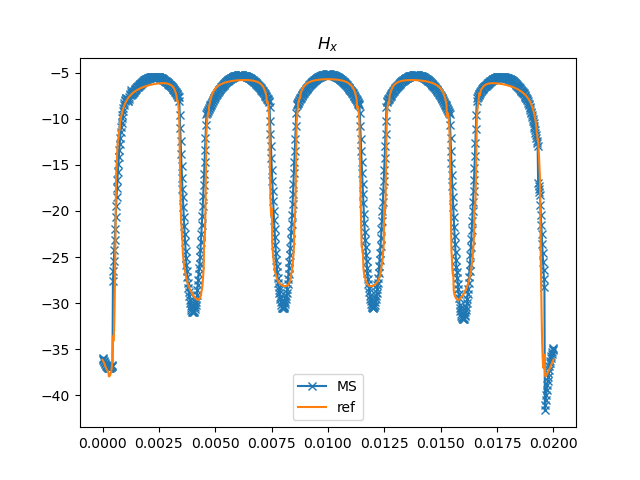

In [31]:
start = -d/2
end = d/2

plt.figure(3)
evalOnLine(H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(H_ref[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_x$");



plt.legend()
plt.show()

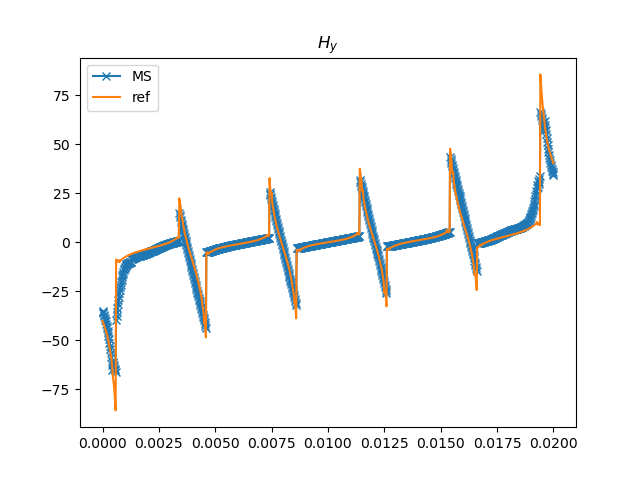

In [32]:
start = -d/2
end = d/2


plt.figure(4)

evalOnLine(H_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# [evalOnLine((H_comp[i])[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS_" + gradgradMS.gradsol_pack[i][1].name, show=False, N=1000) for i in range(len(H_comp))];

evalOnLine(H_ref[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_y$");
plt.legend()
plt.show()

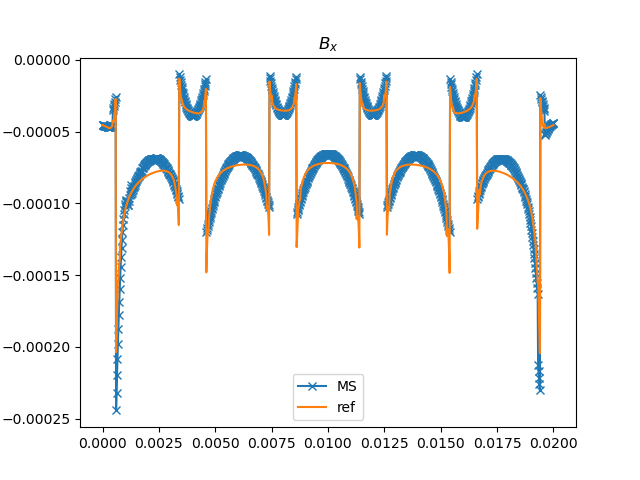

'pyPhiConstant'

In [33]:
start = -d/2
end = d/2

H_comp = gradgradMS.gradsol_comp
plt.figure(5)
evalOnLine(mu * H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
i = 0
# evalOnLine(mu * (H_comp[i])[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=1000);
evalOnLine(mu * H_ref[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_x$");

plt.legend()
plt.show()
gradgradMS.gradsol_pack[0][1].name

pyPhiConstant
pydxLobatto(1)
pyLobatto(1)
pydxLobatto(2)_Fe
pyLobatto(2)_Fe
pydxLobatto(2)_ins
pyLobatto(2)_ins


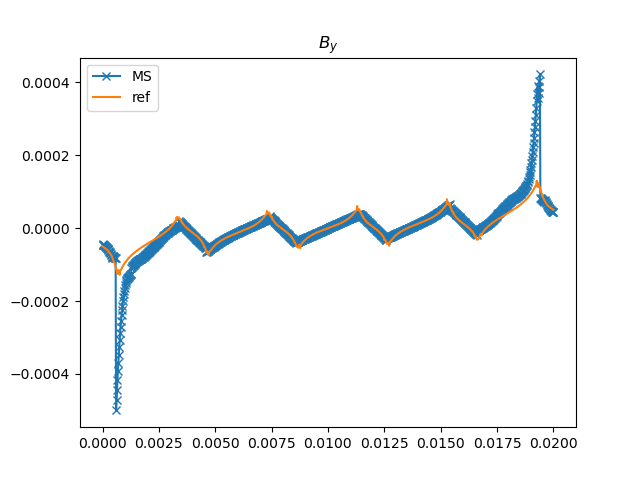

In [34]:
start = -d/2
end = d/2

[print(o[1].name) for o in gradgradMS.gradsol_pack]

plt.figure(6)
H_MS = sum(gradgradMS.gradsol_comp) 
evalOnLine(mu * H_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);

# [evalOnLine(mu * (gradgradMS.gradsol_comp[i])[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS_" + gradgradMS.gradsol_pack[i][1].name, show=False, N=1000) for i in range(len(gradgradMS.gradsol_comp))];

evalOnLine(mu * H_ref[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_y$");

plt.legend()
plt.show()

### Drawings

In [35]:
print(H_ref[1].dim)
print(gradgradMS.gradsol_comp[1].is_complex)

H_MS = sum(gradgradMS.gradsol_comp)
# H_MS = gradgradMS.gradsol_pack[1][1]

print(gradgradMS.gradsol_pack[0][1].name)

L2Draw((H_ref[0], H_MS[0]), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, diff=False)
L2Draw((H_ref[1], H_MS[1]), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, diff=False, min = -10, max=10)



1
False
pyPhiConstant


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [36]:
L2Draw((H_ref[1], H_MS[1]), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, min = -50, max=50)
L2Draw((H_ref[0], H_MS[0]), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, min = -50, max=50)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [37]:
L2Draw((mu *H_ref[0], mu*H_MS[0]), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})
L2Draw((mu *H_ref[1], mu*H_MS[1]), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})
# lamMS = IfPos(cl_Phi(0, 0, inIron=False, material="multiscale").phi, lambda1, lambda2)

# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[0], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[1], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [38]:
L2Draw((B_ref.Norm(), mu * H_MS.Norm()), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, min = 0, max = 1e-4)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [27]:
# print("Norm soll diff", Integrate((sum(sol_comp_MS) - sol_ref)* (sum(sol_comp_MS) - sol_ref)/( (sol_ref)**2) , meshRef)*100,  "%")
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")


diff energy 3.0668649924192125e-07 3.0876040950623074e-07 -2.073910264309498e-09 -0.6716891804963248 %
